In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import scipy.stats as st
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

## データの読み込みと前処理
#### download.pyでデータをダウンロード

In [3]:
url = 'data/auto-mpg.tsv'
df_org = pd.read_table(url, sep='\t', header=0)

In [4]:
df = df_org[['mpg', 'weight']].dropna()
df['weight'] /= (10 ** 3)
df['weight_sqr'] = df['weight'] ** 2
df['weight_cub'] = df['weight'] ** 3
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 405
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mpg         398 non-null    float64
 1   weight      398 non-null    float64
 2   weight_sqr  398 non-null    float64
 3   weight_cub  398 non-null    float64
dtypes: float64(4)
memory usage: 15.5 KB


,mpg,weight,weight_sqr,weight_cub
0,18.0,3.504,12.278016,43.022168
1,15.0,3.693,13.638249,50.366054
2,18.0,3.436,11.806096,40.565746
3,16.0,3.433,11.785489,40.459584
4,17.0,3.449,11.895601,41.027928


## ベイズ回帰モデル

In [5]:
def polynomial_regmodel(
    tau, intercept, p_1d, p_2d, p_3d, x_obs, y_obs
):

    with pm.Model() as model:
        x = pm.Data('x', x_obs)
        w0 = pm.Normal('w0', mu=intercept['mu'], tau=intercept['tau'])
        w1 = pm.Normal('w1', mu=p_1d['mu'], tau=p_1d['tau'])
        w2 = pm.Normal('w2', mu=p_2d['mu'], tau=p_2d['tau'])
        w3 = pm.Normal('w3', mu=p_3d['mu'], tau=p_3d['tau'])
        y_mean = w0 + w1 * x + w2 * (x ** 2) + w3 * (x ** 3)
        y = pm.Normal('y', mu=y_mean, tau=tau, observed=y_obs)

    return model


def hierarchical_polynomial_regmodel(
    tau, intercept, p_1d, p_2d, p_3d, x_obs, y_obs
):

    with pm.Model() as model:

        x = pm.Data('x', x_obs)

        mu_0 = pm.Normal('mu0', mu=intercept['mu'], tau=intercept['tau'])
        tau_0 = pm.Gamma('tau0', alpha=intercept['alpha'], beta=intercept['beta'])
        w0 = pm.Normal('w0', mu=mu_0, tau=tau_0)

        mu_1 = pm.Normal('mu1', mu=p_1d['mu'], tau=p_1d['tau'])
        tau_1 = pm.Gamma('tau1', alpha=p_1d['alpha'], beta=p_1d['beta'])
        w1 = pm.Normal('w1', mu=mu_1, tau=tau_1)

        mu_2 = pm.Normal('mu2', mu=p_2d['mu'], tau=p_2d['tau'])
        tau_2 = pm.Gamma('tau2', alpha=p_2d['alpha'], beta=p_2d['beta'])
        w2 = pm.Normal('w2', mu=mu_2, tau=tau_2)

        mu_3 = pm.Normal('mu3', mu=p_3d['mu'], tau=p_3d['tau'])
        tau_3 = pm.Gamma('tau3', alpha=p_3d['alpha'], beta=p_3d['beta'])
        w3 = pm.Normal('w3', mu=mu_3, tau=tau_3)

        y_mean = w0 + w1 * x + w2 * (x ** 2) + w3 * (x ** 3)
        y = pm.Normal('y', mu=y_mean, tau=tau, observed=y_obs)

    return model


In [6]:
tau = 1 / 9
intercept = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_1d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_2d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_3d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}

x, y = df['weight'].values[:10], df['mpg'].values[:10]

model = hierarchical_polynomial_regmodel(
    tau, intercept, p_1d, p_2d, p_3d, x, y
)

### グラフィカルモデル

In [7]:
gv = pm.model_to_graphviz(model)
gv.format = 'png'
gv.render(filename='figures/graphical_model')

'figures/graphical_model.png'

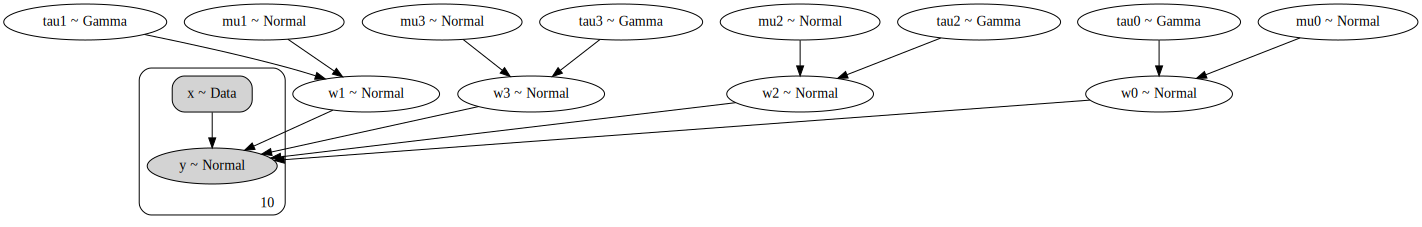

In [8]:
pm.model_to_graphviz(model)

In [9]:
def simulation(model):

    with model:
        prior = pm.sample_prior_predictive()
        posterior = pm.sample()

    return prior, posterior


def plot_reg_simulation(model, x_obs, y_obs):

    prior, posterior = simulation(model)
    x = np.linspace(min(x_obs), max(x_obs), 100)

    for i in range(len(posterior['w0'])):
        w0 = posterior['w0'][i]
        w1 = posterior['w1'][i]
        w2 = posterior['w2'][i]
        w3 = posterior['w3'][i]
        y = w0 + w1 * x + w2 * (x ** 2) + w3 * (x ** 3)
        plt.plot(x, y, alpha=0.01)

    plt.scatter(x_obs, y_obs, c='r', s=20)

    return prior, posterior


def get_mean_coef(posterior):

    w0 = posterior['w0']
    w1 = posterior['w1']
    w2 = posterior['w2']
    w3 = posterior['w3']

    return np.array([np.mean(w0), np.mean(w1), np.mean(w2), np.mean(w3)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, tau3, mu3, w2, tau2, mu2, w1, tau1, mu1, w0, tau0, mu0]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 229.65draws/s]
The acceptance probability does not match the target. It is 0.8833126560257094, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


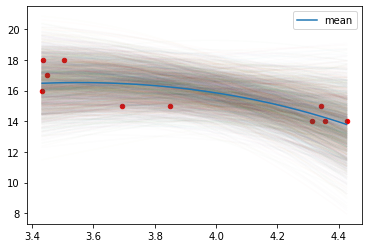

In [10]:
_, posterior = plot_reg_simulation(model, x, y)

w0, w1, w2, w3 = get_mean_coef(posterior)
x_ = np.linspace(min(x), max(x), 100)
y_pred = w0 + w1 * x_ + w2 * (x_ ** 2) + w3 * (x_ ** 3)
plt.plot(x_, y_pred, label='mean')
plt.legend()
plt.show()

## 最小二乗回帰との比較

In [11]:
def function_3d(w, x):
    return w[0] + np.dot(x, w[1:])

In [12]:
from sklearn.model_selection import train_test_split

X, y = df[['weight', 'weight_sqr', 'weight_cub']].values, df['mpg'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)
print('train:\t', len(X_train))
print('test:\t', len(X_test))


# OLS
ols_model = LinearRegression().fit(X_train, y_train)

# bayes
tau = 1 / 9
intercept = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_1d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_2d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_3d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}

bayes_model = hierarchical_polynomial_regmodel(
    tau, intercept, p_1d, p_2d, p_3d, X_train[:, 0], y_train
)


train:	 278
test:	 120


In [13]:
_, posterior = simulation(bayes_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, tau3, mu3, w2, tau2, mu2, w1, tau1, mu1, w0, tau0, mu0]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:45<00:00, 88.39draws/s] 
The acceptance probability does not match the target. It is 0.9250646703906072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9275053484770381, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9014933990733454, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [14]:
ols_coef = np.array([ols_model.intercept_] + ols_model.coef_.tolist())
print(ols_coef)
bayes_coef = get_mean_coef(posterior)
print(bayes_coef)

[ 73.47776972 -29.89987066   5.32584738  -0.36457076]
[47.53071318 -4.41724419 -2.6022946   0.42129909]


## 学習データ数を変えてMSEを調べる

In [15]:
from IPython.display import clear_output
import random
from sklearn.metrics import mean_squared_error

idx_all = np.arange(0, len(X_train)).tolist()
n_samples = [2 ** i for i in range(2, 9)]
mse_history = {'ols': [], 'bayes': []}

tau = 1 / 9
intercept = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_1d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_2d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_3d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}

num_iters = 10
for n in n_samples:
    mse_history['ols'].append(0)
    mse_history['bayes'].append(0)

    for iter in range(num_iters):
        random.seed(iter)
        idx = random.sample(idx_all, n)

        # OLS
        ols_model = LinearRegression().fit(X_train[idx], y_train[idx])
        y_pred_ols = ols_model.predict(X_test)
        mse_ols = mean_squared_error(y_test, y_pred_ols)
        mse_history['ols'][-1] += mse_ols

        # bayes
        bayes_model = hierarchical_polynomial_regmodel(
            tau, intercept, p_1d, p_2d, p_3d, X_train[:, 0][idx], y_train[idx]
        )
        _, posterior = simulation(bayes_model)
        bayes_coef = get_mean_coef(posterior)
        y_pred_bayes = function_3d(bayes_coef, X_test)
        mse_bayes = mean_squared_error(y_test, y_pred_bayes)
        mse_history['bayes'][-1] += mse_bayes

    mse_history['ols'][-1] /= num_iters
    mse_history['bayes'][-1] /= num_iters

clear_output()

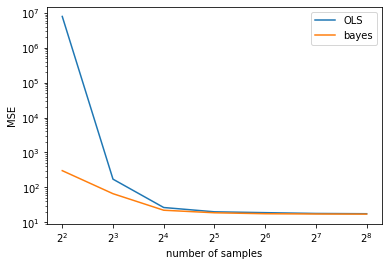

In [16]:
fig, ax = plt.subplots()

ax.plot(n_samples, mse_history['ols'], label='OLS')
ax.plot(n_samples, mse_history['bayes'], label='bayes')

ax.set_xlabel('number of samples')
ax.set_ylabel('MSE')
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=10)
plt.legend()
plt.savefig('figures/mse.jpg')
plt.show()

In [20]:
print(mse_history['ols'])
print(mse_history['bayes'])

[7918692.746985303, 171.00715480915164, 26.31231636697825, 19.82108930138111, 18.73961075236511, 17.770075348968742, 17.460508275829703]
[299.95457795807266, 65.52770818984347, 21.987649691031976, 18.59239165196848, 17.453027516742537, 17.147163266945494, 17.016735797078287]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, tau3, mu3, w2, tau2, mu2, w1, tau1, mu1, w0, tau0, mu0]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 332.01draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


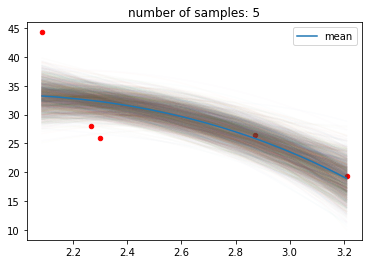

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, tau3, mu3, w2, tau2, mu2, w1, tau1, mu1, w0, tau0, mu0]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:28<00:00, 142.81draws/s]
The acceptance probability does not match the target. It is 0.8898112284774975, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


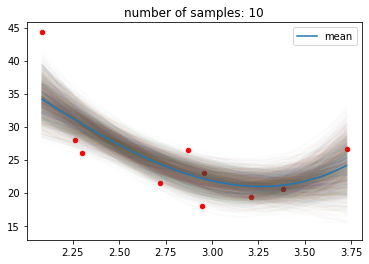

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, tau3, mu3, w2, tau2, mu2, w1, tau1, mu1, w0, tau0, mu0]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:28<00:00, 142.02draws/s]
The acceptance probability does not match the target. It is 0.9395671059089095, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837197409778338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878752493492393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9452798251995769, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


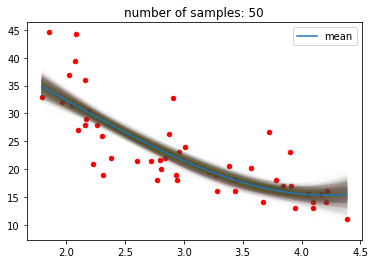

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, tau3, mu3, w2, tau2, mu2, w1, tau1, mu1, w0, tau0, mu0]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:29<00:00, 134.93draws/s]
The acceptance probability does not match the target. It is 0.962920134499403, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939799839758376, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


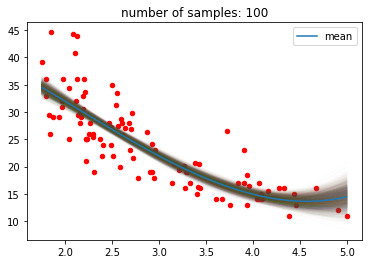

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, tau3, mu3, w2, tau2, mu2, w1, tau1, mu1, w0, tau0, mu0]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:50<00:00, 78.84draws/s] 
The acceptance probability does not match the target. It is 0.9344977953548066, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9065103583721784, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872286185522524, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


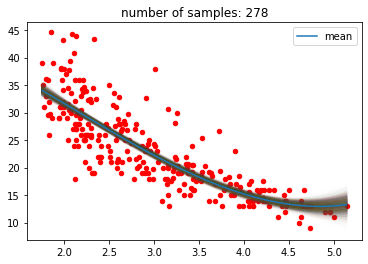

In [17]:
import random

n_samples = [5, 10, 50, 100, len(X_train)]

tau = 1 / 9
intercept = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_1d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_2d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}
p_3d = {'mu': 0, 'tau': 1 / 9, 'alpha': 1, 'beta': 1}


for n in n_samples:
    random.seed(0)
    idx = random.sample(idx_all, n)
    x, y = X_train[:, 0][idx], y_train[idx]

    # bayes
    bayes_model = hierarchical_polynomial_regmodel(
        tau, intercept, p_1d, p_2d, p_3d, x, y
    )
    _, posterior = plot_reg_simulation(bayes_model, x, y)

    w0, w1, w2, w3 = get_mean_coef(posterior)
    x_ = np.linspace(min(x), max(x), 100)
    y_pred = w0 + w1 * x_ + w2 * (x_ ** 2) + w3 * (x_ ** 3)
    plt.plot(x_, y_pred, label='mean')
    plt.title('number of samples: {}'.format(n))
    plt.legend()
    plt.savefig('figures/bayes_{}.jpg'.format(n))
    plt.show()